# **0 - Imports and Kaggle setup**

## Imports

In [ ]:
# !pip install category_encoders

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Bayesian Analysis")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import category_encoders as ce

import sklearn
import imblearn
import xgboost as xgb

import sklearn.metrics as metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge, Ridge

import pymc as pm
import arviz as az

pd.set_option('display.max_columns', None)

## Kaggle setup

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [ ]:
!kaggle datasets download -d nikhilbhathi/data-scientist-salary-us-glassdoor

In [ ]:
!ls

 bayesian_tree		 helper_functions.py  'Outline and ideas.docx'	 Salary_Prediction.ipynb
 bike_sales_data.csv	 LR.ipynb	       project.ipynb		 Untitled.ipynb
 data_cleaned_2021.csv	 onlinefoods.csv       __pycache__


In [ ]:
import zipfile

zip_file_path = "data-scientist-salary-us-glassdoor.zip"

# Define the directory where you want to extract the contents
extract_dir = "."

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

# Optionally, you can remove the zip file after extraction
os.remove(zip_file_path)

## Functions

In [ ]:
def get_data(string):
    data = pd.read_csv(string)
    data.drop(['index',
               'Founded',
               'Rating',
               'Job Title',
               'Salary Estimate',
               'Job Description',
               'Company Name',
               'Location',
               'Headquarters',
               'Industry',
               'Competitors',
               'Hourly',
              'Employer provided',
              'company_txt',
               'Job Location',
               'seniority_by_title',
              'Lower Salary',
               'Upper Salary',
              'Degree'], axis=1, inplace=True)



    for col in data.columns:
        data[col] = data[col].replace('-1', pd.NA)
        data[col] = data[col].replace('na', pd.NA)
        data[col] = data[col].replace(-1, pd.NA)
        data[col] = data[col].replace('unknown', pd.NA)
        data[col] = data[col].replace('Unknown / Non-Applicable', pd.NA)

    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)


    return data

In [ ]:
def inspect_data(data):
    print(data.head(3))
    print('#############################################################')
    print("Shape:\n", data.shape)
    print('#############################################################')
    print("Info:\n", data.info())
    print('#############################################################')
    print('Null values:\n', data.isnull().sum())
    print('#############################################################')
    for col in data.columns:
        print(f"Column: {col}", data[col].value_counts(normalize=True),
              "\n--------------------------------------------------")





In [ ]:
def encode_data(X, y):

    # Ordinal Encoding
    size_mapping = {'1 - 50 ': 0,
                '51 - 200 ': 1,
                '201 - 500 ': 2,
                '501 - 1000 ': 3,
                '1001 - 5000 ': 4,
                '5001 - 10000 ': 5,
                '10000+ ': 6}

    revenue_mapping = {'$1 to $5 million (USD)': 0,
                        '$5 to $10 million (USD)': 1,
                        '$10 to $25 million (USD)': 2,
                        '$25 to $50 million (USD)': 3,
                        '$50 to $100 million (USD)': 4,
                        '$100 to $500 million (USD)': 5,
                        '$500 million to $1 billion (USD)': 6,
                        '$1 to $2 billion (USD)': 7,
                        '$2 to $5 billion (USD)': 8,
                        '$5 to $10 billion (USD)': 9,
                        '$10+ billion (USD)':10}

    # Apply mapping to the respective columns
    X.loc[:, 'Size'] = X['Size'].map(size_mapping)
    X.loc[:, 'Revenue'] = X['Revenue'].map(revenue_mapping)

    # Other Category Encoding (evaluate what to do)
    encoder = ce.TargetEncoder(cols=['Type of ownership'])
    X = encoder.fit_transform(X, y)

    encoder = ce.TargetEncoder(cols=['Sector'])
    X = encoder.fit_transform(X, y)

    encoder = ce.TargetEncoder(cols=['job_title_sim'])
    X = encoder.fit_transform(X, y)

    return pd.concat([X,y], axis=1)

In [ ]:
def split(data):

    data_shuffled = data.sample(frac=1, random_state=42)  # Shuffle with a fixed random_state for reproducibility

    # Calculate the index to split the data (80% for training, 20% for testing)
    train_size = int(0.8 * len(data_shuffled))

    # Split the data into training and testing sets
    train = data_shuffled.iloc[:train_size]
    test = data_shuffled.iloc[train_size:]

    return train, test

In [ ]:
def train_test(X,y, test_size = 0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataframe(data):
    binary_cols = [col for col in data.columns if data[col].nunique() == 2]
    non_binary_cols = [col for col in data.columns if col not in binary_cols]

    scaler = MinMaxScaler()
    scaled_numericals = scaler.fit_transform(data[non_binary_cols])

    scaled_data = data.copy()
    scaled_data[non_binary_cols] = scaled_numericals
    return scaled_data

In [ ]:
def feature_eng(X_scaled):

    # Create a column which sums 'Programming Language'
    X_scaled['Programming'] = X_scaled['Python'] + X_scaled['sas']

    # Create a column which sums 'Queries'
    X_scaled['Queries'] = X_scaled['mongo'] + X_scaled['sql']

    # Create a column which sums 'DeepLearning'
    X_scaled['Machine Learning'] = X_scaled['keras'] + X_scaled['pytorch'] + X_scaled['tensor'] + X_scaled['scikit']

    # Create a column which sums 'Dashboards'
    X_scaled['Dashboards'] = X_scaled['bi'] + X_scaled['tableau'] + X_scaled['excel']

    # Create a column which sums 'Cloud'
    X_scaled['Cloud'] = X_scaled['aws'] + X_scaled['google_an']

    # Create a column which sums 'Apache'
    X_scaled['Apache'] = X_scaled['flink'] + X_scaled['spark'] + X_scaled['hadoop']


    X_scaled.drop(['Size', 'Age',
                  'Python', 'spark', 'aws', 'sql', 'sas', 'keras', 'pytorch',
                  'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an',
                  'excel', 'scikit'],
                  axis=1,
                  inplace=True)

    return X_scaled

In [ ]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# **1 - Load the data and perform pre-processing steps, including Encoding, Scaling and EDA**

## Getting data

In [ ]:
data = get_data('data_cleaned_2021.csv')

In [ ]:
data.columns

Index(['Size', 'Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'Age', 'Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras',
       'pytorch', 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink',
       'mongo', 'google_an', 'job_title_sim'],
      dtype='object')

In [ ]:
inspect_data(data)

          Size   Type of ownership               Sector  \
0  501 - 1000    Company - Private  Aerospace & Defense   
1      10000+   Other Organization          Health Care   
2  501 - 1000    Company - Private    Business Services   

                      Revenue  Avg Salary(K) Age  Python  spark  aws  excel  \
0   $50 to $100 million (USD)           72.0  48       1      0    0      1   
1      $2 to $5 billion (USD)           87.5  37       1      0    0      0   
2  $100 to $500 million (USD)           85.0  11       1      1    0      1   

   sql  sas  keras  pytorch  scikit  tensor  hadoop  tableau  bi  flink  \
0    0    1      0        0       0       0       0        1   1      0   
1    0    0      0        0       0       0       0        0   0      0   
2    1    1      0        0       0       0       0        0   0      0   

   mongo  google_an   job_title_sim  
0      0          0  data scientist  
1      0          0  data scientist  
2      0          0  data scien

### Outlier with InterQuartile Range

During our analysis in subsequent chapters of this notebook, we have noticed that the target variable is affected by severe outliers. Our approach is to identify them, and then to replace them using the `median value` of the target variable itself.

Text(0.5, 1.0, 'BoxPlot for the target variable')

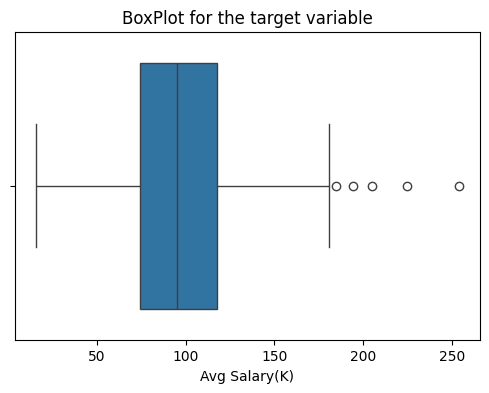

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable')

In [ ]:
Q1 = data['Avg Salary(K)'].quantile(0.25)
Q3 = data['Avg Salary(K)'].quantile(0.75)

IQR = Q3 - Q1

# Define lower and upper bounds for outliers for the 'Avg Salary(K)' column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the 'Avg Salary(K)' column
outliers = (data['Avg Salary(K)'] < lower_bound) | (data['Avg Salary(K)'] > upper_bound)

# Count outliers in the 'Avg Salary(K)' column
outlier_count = outliers.sum()

# Display the modified DataFrame
print("Outliers detected:", outlier_count)


data = data[(data['Avg Salary(K)'] >= lower_bound) & (data['Avg Salary(K)'] <= upper_bound)]

Outliers detected: 5


Text(0.5, 1.0, 'BoxPlot for the target variable - after the outlier deletion')

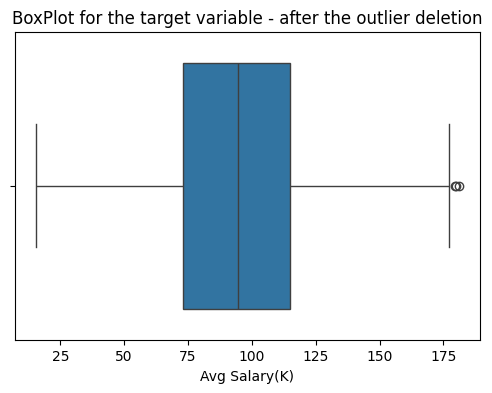

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable - after the outlier deletion')

## Encoding data

In [ ]:
encoded_data = encode_data(X=data.drop(columns=['Avg Salary(K)']), y=data['Avg Salary(K)'])

In [ ]:
encoded_data.head()

,Size,Type of ownership,Sector,Revenue,Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,Avg Salary(K)
0,3,92.697999,98.158393,4,48,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,109.32472,72.0
1,6,92.781804,89.770672,8,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,109.32472,87.5
2,3,92.697999,90.410945,5,11,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,109.32472,85.0
3,4,95.913139,94.108033,6,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,109.32472,76.5
5,2,109.457523,98.555997,7,21,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,109.32472,95.0


### Features Engineering

In [ ]:
encoded_data = feature_eng(encoded_data)
encoded_data.head()

,Type of ownership,Sector,Revenue,job_title_sim,Avg Salary(K),Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,92.697999,98.158393,4,109.32472,72.0,2,0,0,3,0,0
1,92.781804,89.770672,8,109.32472,87.5,1,0,0,0,0,0
2,92.697999,90.410945,5,109.32472,85.0,2,1,0,1,0,1
3,95.913139,94.108033,6,109.32472,76.5,1,0,0,0,0,0
5,109.457523,98.555997,7,109.32472,95.0,1,2,0,2,1,0


## Scaling data

In [ ]:
train, test = split(encoded_data)

In [ ]:
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns= train.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [ ]:
X_train = train.loc[:, train.columns != 'Avg Salary(K)']
y_train = train['Avg Salary(K)']

X_test = test.loc[:, test.columns != 'Avg Salary(K)']
y_test = test['Avg Salary(K)']

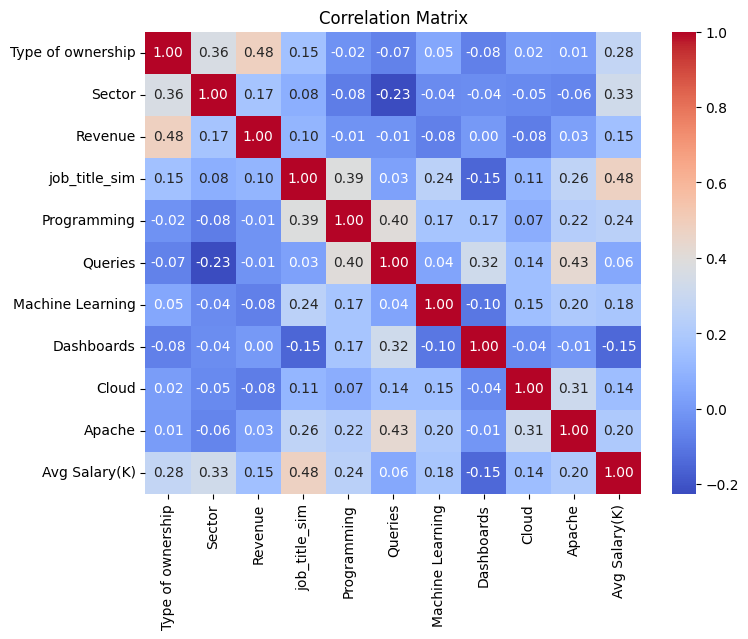

In [ ]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

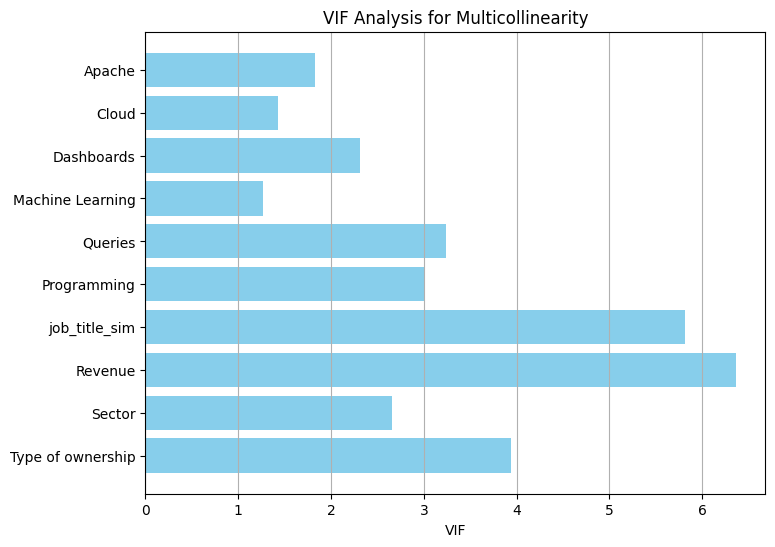

In [ ]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Plot VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data["Feature"], vif_data["VIF"], color='skyblue')
plt.xlabel('VIF')
plt.title('VIF Analysis for Multicollinearity')
plt.grid(axis='x')
plt.show()

## Box plots scaled df

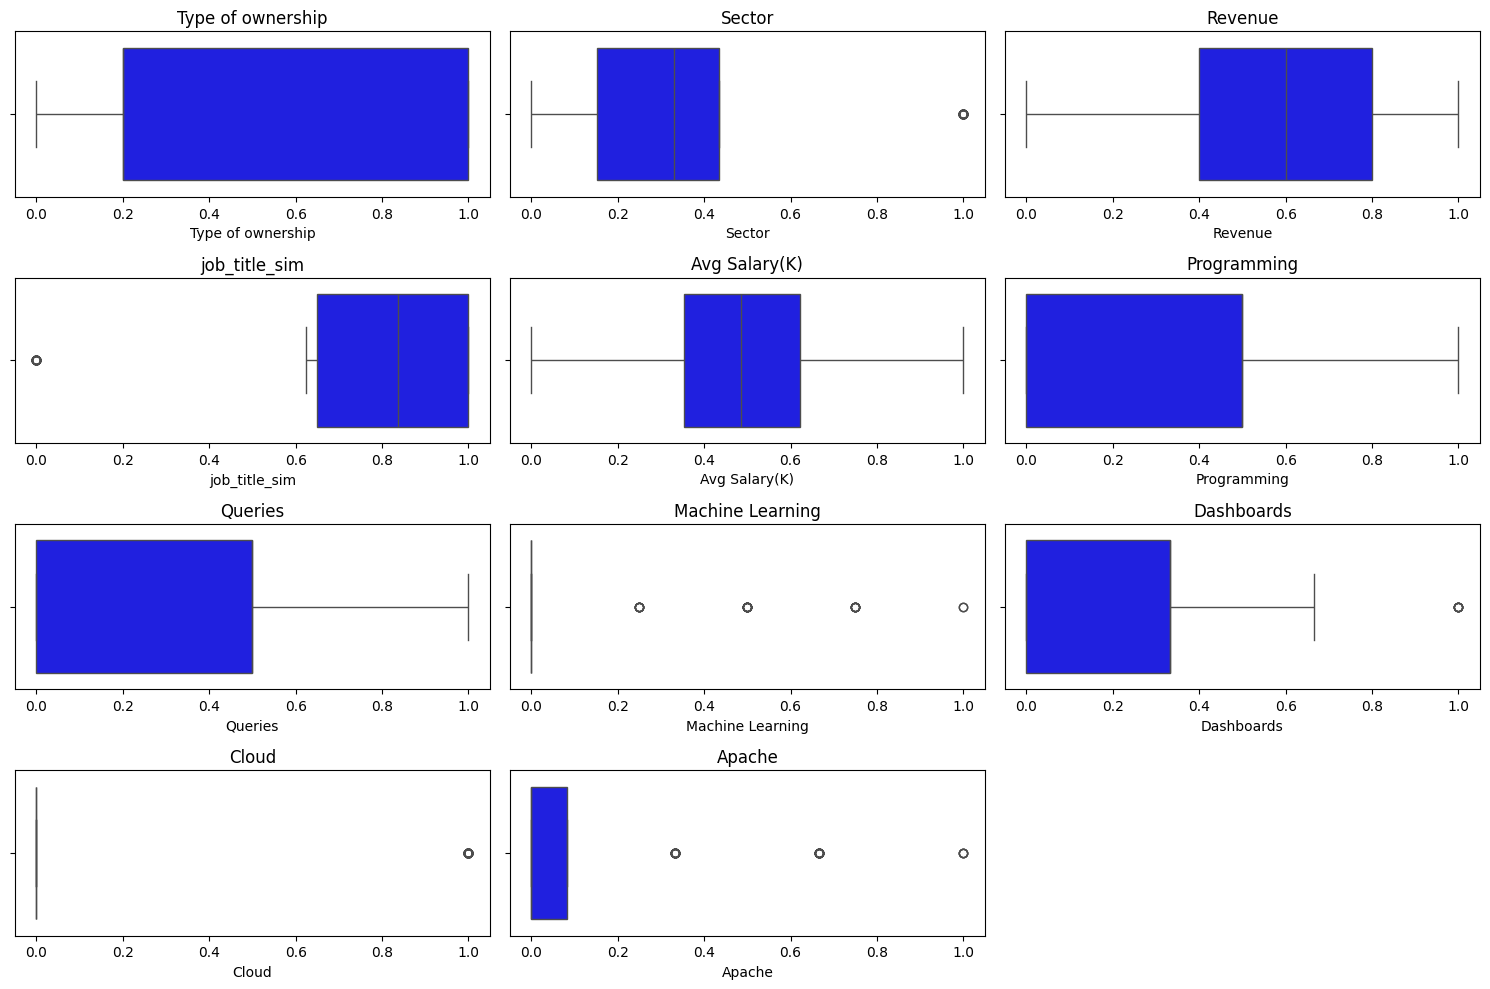

In [ ]:
# Filter numerical and binary columns
numerical_columns = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in train.columns if train[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=train[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

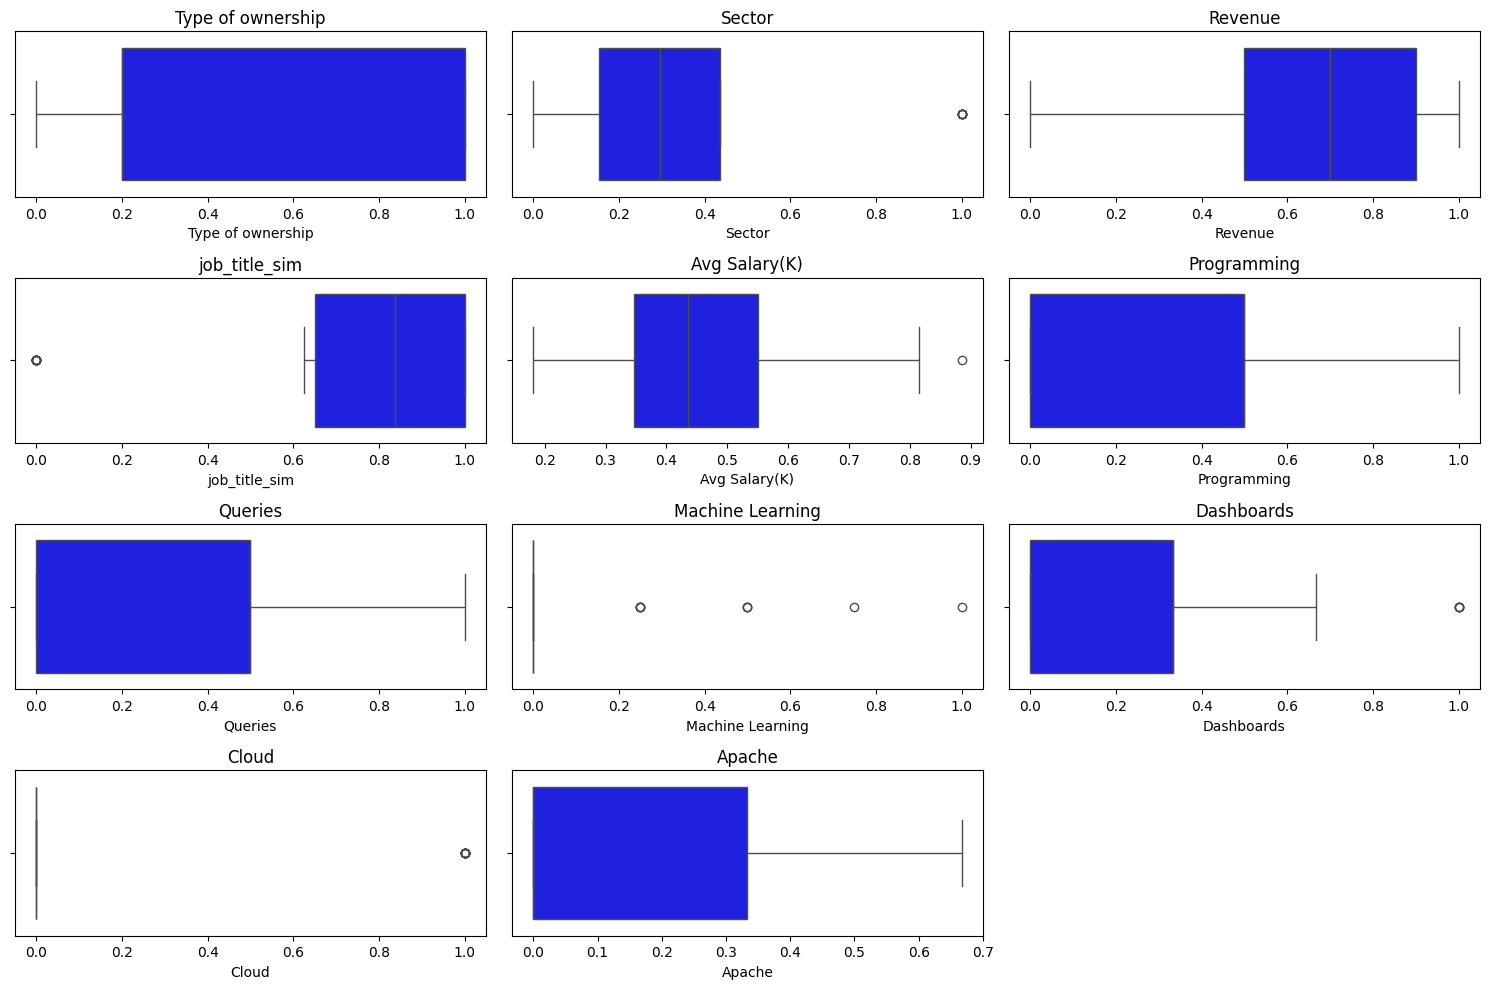

In [ ]:
# Filter numerical and binary columns
numerical_columns = [col for col in test.columns if test[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in test.columns if test[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=test[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **2 - Linear Regression, including frequentist and Bayesian approaches**

## frequentist LR

In [ ]:
# Normal Linear Regression
normal_lr = LinearRegression()
normal_lr.fit(X_train, y_train)

y_val_predictions_nlr = normal_lr.predict(X_test)

In [ ]:
regression_results(y_test, y_val_predictions_nlr)

explained_variance:  0.1764
mean_squared_log_error:  0.0087
r2:  0.1466
MAE:  0.116
MSE:  0.0193
RMSE:  0.1388


## bayesian LR - non informative Normal priors

How to model the prior distributions?
- all the skills variables can be modeled using a Bernoulli Distribution, since they are dummy variables;
- Size can be modeled using a uniform distribution defined between size.min() and size.max()
- Type of ownership can be modeled using a uniform distribution defined between Type of ownership.min() and Type of ownership.max()
- Sector can be modeled using a uniform distribution defined between Sector.min() and Sector.max()
- Revenue can be modeled using a uniform distribution defined between Revenue.min() and Revenue.max()
- job_title_sim can be modeled using a uniform distribution defined between job_title_sim.min() and job_title_sim.max()

In [ ]:
# Define Bayesian Linear Regression model
with pm.Model() as bayesian_lr_model:
    # Priors for coefficients
    beta_0 = pm.Normal('intercept', mu=0, sigma=10)  # Prior for intercept
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])  # Prior for coefficients

    # Linear regression equation
    mu = beta_0 + pm.math.dot(beta, X_train.values.T)

    # Likelihood (sampling distribution)
    sigma = pm.HalfNormal('sigma', sigma=10)  # Prior for the standard deviation of the noise
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train.values)  # Likelihood function

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, cores=1)

In [ ]:
X_train.columns

Index(['Type of ownership', 'Sector', 'Revenue', 'job_title_sim',
       'Programming', 'Queries', 'Machine Learning', 'Dashboards', 'Cloud',
       'Apache'],
      dtype='object')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.204,0.040,0.132,0.282,0.001,0.001,2807.0,2905.0,1.0
beta[0],0.054,0.036,-0.014,0.120,0.001,0.000,3514.0,2758.0,1.0
beta[1],0.192,0.039,0.121,0.266,0.001,0.000,3754.0,3137.0,1.0
beta[2],0.023,0.049,-0.070,0.117,0.001,0.001,3521.0,3010.0,1.0
beta[3],0.213,0.039,0.139,0.284,0.001,0.000,3187.0,2770.0,1.0
beta[4],0.068,0.045,-0.021,0.150,0.001,0.001,4457.0,3255.0,1.0
beta[5],0.064,0.049,-0.027,0.157,0.001,0.001,3397.0,2970.0,1.0
beta[6],0.057,0.060,-0.054,0.170,0.001,0.001,4326.0,2974.0,1.0
beta[7],-0.090,0.046,-0.172,-0.000,0.001,0.001,4493.0,3150.0,1.0
beta[8],0.038,0.029,-0.017,0.089,0.000,0.000,3888.0,2848.0,1.0


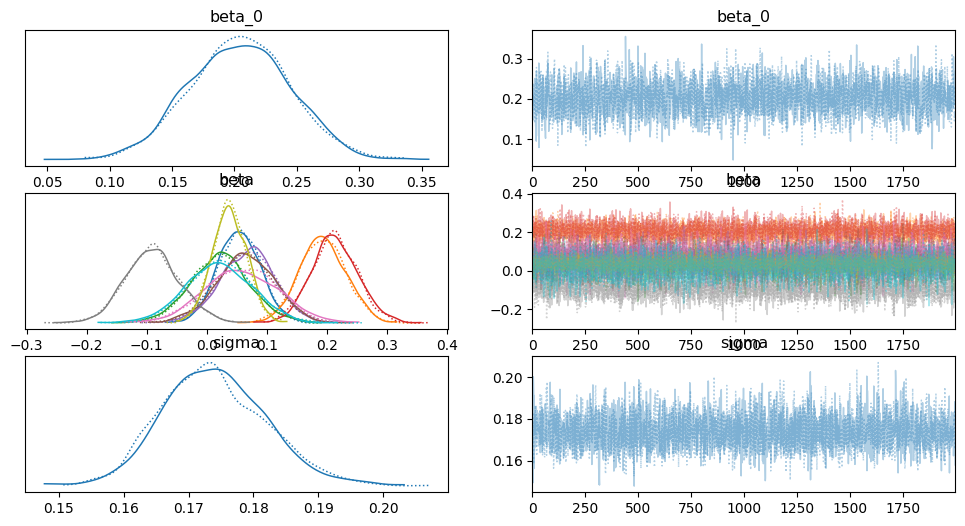

In [ ]:
# Plot posterior distributions
pm.plot_trace(trace)

# Summarize posterior statistics
pm.summary(trace)

In [ ]:
trace_df = az.InferenceData.to_dataframe(trace)
trace_df.head(4)

,chain,draw,"(posterior, intercept)","(posterior, beta[0], 0)","(posterior, beta[1], 1)","(posterior, beta[2], 2)","(posterior, beta[3], 3)","(posterior, beta[4], 4)","(posterior, beta[5], 5)","(posterior, beta[6], 6)","(posterior, beta[7], 7)","(posterior, beta[8], 8)","(posterior, beta[9], 9)","(posterior, sigma)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, max_energy_error)","(sample_stats, acceptance_rate)","(sample_stats, smallest_eigval)","(sample_stats, reached_max_treedepth)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)","(sample_stats, perf_counter_start)","(sample_stats, energy)","(sample_stats, energy_error)","(sample_stats, process_time_diff)","(sample_stats, step_size_bar)","(sample_stats, tree_depth)","(sample_stats, step_size)","(sample_stats, diverging)","(sample_stats, n_steps)"
0,0,0,0.268803,0.055392,0.222744,0.033220,0.116058,0.065041,0.149451,0.110420,-0.208339,0.039087,0.018588,0.168706,38.087562,-23,-0.100457,0.993428,NaN,False,NaN,0.011396,17471.374822,-30.045549,0.015127,0.010533,0.243477,5,0.292602,False,31.0
1,0,1,0.197075,0.056752,0.174417,-0.016499,0.234518,0.084507,0.001085,0.082891,0.003876,0.044219,0.018405,0.177205,42.499394,9,0.252255,0.899410,NaN,False,NaN,0.004612,17471.386524,-35.425460,-0.020836,0.004606,0.243477,4,0.292602,False,15.0
2,0,2,0.177644,0.085175,0.162727,-0.001697,0.269665,0.045105,-0.002195,0.018254,-0.057912,0.023436,0.064410,0.165352,41.749885,5,0.258231,0.904376,NaN,False,NaN,0.005158,17471.391462,-38.444683,0.252675,0.005031,0.243477,4,0.292602,False,15.0
3,0,3,0.161516,-0.003514,0.261769,0.046694,0.226147,0.030252,0.076952,0.042548,-0.048204,0.038946,0.063961,0.176375,41.966201,8,-0.320631,0.991157,NaN,False,NaN,0.008972,17471.396919,-36.093987,-0.093359,0.008878,0.243477,5,0.292602,False,31.0


In [ ]:
coefficients_dict = dict(zip(pm.summary(trace)['mean'][:11].index,
                        pm.summary(trace)['mean'][:11].values))
coefficients_dict

{'intercept': 0.205,
 'beta[0]': 0.054,
 'beta[1]': 0.192,
 'beta[2]': 0.023,
 'beta[3]': 0.212,
 'beta[4]': 0.068,
 'beta[5]': 0.063,
 'beta[6]': 0.057,
 'beta[7]': -0.091,
 'beta[8]': 0.037,
 'beta[9]': 0.024}

In [ ]:
lr_model = LinearRegression()

# Set Coefficients
# Extract coefficients from the dictionary
intercept = np.array(coefficients_dict['intercept'])
coefficients = np.array(list(coefficients_dict.values())[1:])

# Set coefficients in the logistic regression model
lr_model.intercept_ = np.array([intercept])
lr_model.coef_ = np.array([coefficients])

# Fit the Model
y_val_predictions = lr_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
regression_results(y_test, y_val_predictions)

explained_variance:  0.1747
mean_squared_log_error:  0.0088
r2:  0.1435
MAE:  0.1162
MSE:  0.0193
RMSE:  0.1391


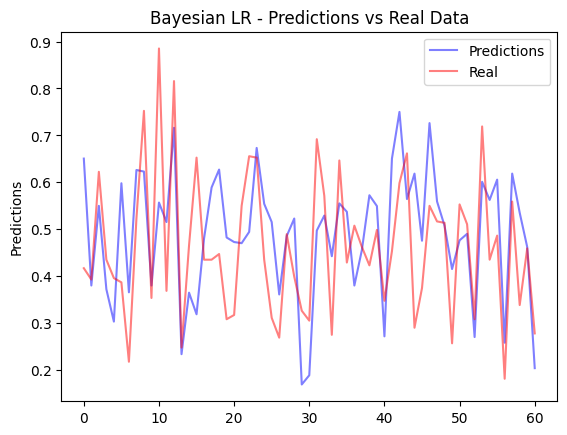

In [ ]:
x_axis = np.arange(len(y_test))

plt.plot(x_axis, y_val_predictions, color='blue', alpha=0.5, label='Predictions')
plt.plot(x_axis, y_test, color='red', alpha=0.5, label='Real')
plt.ylabel('Predictions')
plt.title('Bayesian LR - Predictions vs Real Data')
plt.legend()
plt.show()

## Bayesian Linear Regression - Student-T Priors

The variables will have a suffix "_t" which distinguish them from the previus B-LR which used Normal priors.

In [ ]:
# Define Bayesian Linear Regression model with Student's t priors
with pm.Model() as bayesian_t_model:

    # Priors for coefficients
    intercept_t = pm.StudentT('intercept', nu=1, mu=0, sigma=10)  # Prior for intercept
    beta_t = pm.StudentT('beta', nu=1, mu=0, sigma=10, shape=X_train.shape[1])  # Prior for coefficients

    # Linear regression equation
    mu_t = intercept_t + pm.math.dot(beta_t, X_train.values.T)

    # Likelihood
    sigma_t = pm.HalfStudentT('sigma', nu=1, sigma=10)  # Prior for the standard deviation of the noise
    y_obs_t = pm.Normal('y_obs', mu=mu_t, sigma=sigma_t, observed=y_train.values)  # Likelihood function

    # Sample from the posterior distribution
    trace_t = pm.sample(2000, tune=1000, cores=1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.204,0.040,0.131,0.284,0.001,0.001,2678.0,3201.0,1.0
beta[0],0.054,0.035,-0.014,0.119,0.001,0.000,3579.0,2937.0,1.0
beta[1],0.194,0.039,0.120,0.265,0.001,0.000,5127.0,3074.0,1.0
beta[2],0.022,0.049,-0.072,0.111,0.001,0.001,3124.0,2696.0,1.0
beta[3],0.214,0.039,0.138,0.283,0.001,0.000,3328.0,2946.0,1.0
beta[4],0.067,0.045,-0.022,0.148,0.001,0.001,3299.0,2690.0,1.0
beta[5],0.065,0.049,-0.021,0.161,0.001,0.001,3006.0,2587.0,1.0
beta[6],0.058,0.062,-0.060,0.176,0.001,0.001,4658.0,2938.0,1.0
beta[7],-0.090,0.046,-0.174,-0.003,0.001,0.001,4458.0,3398.0,1.0
beta[8],0.037,0.028,-0.013,0.092,0.000,0.000,4215.0,2588.0,1.0


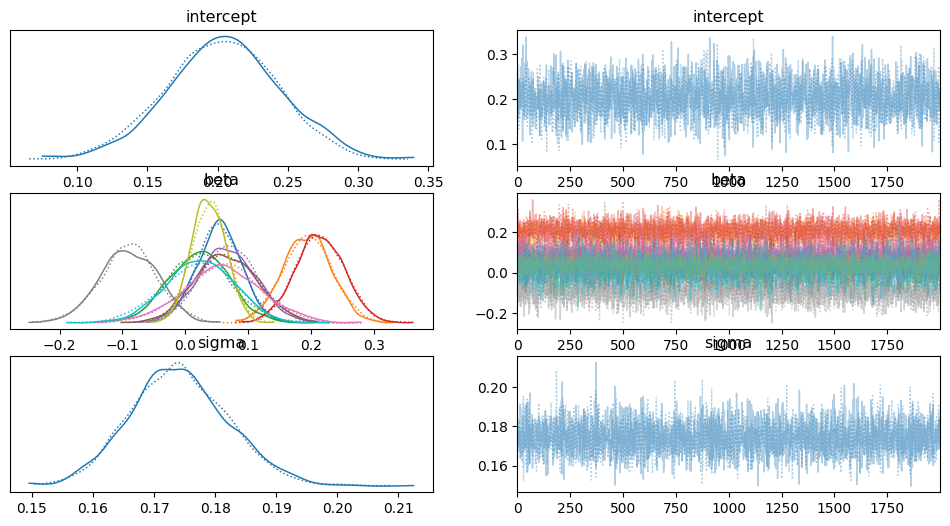

In [ ]:
# Plot posterior distributions
pm.plot_trace(trace_t)

# Summarize posterior statistics
pm.summary(trace_t)

In [ ]:
trace_df_t = az.InferenceData.to_dataframe(trace_t)
trace_df_t.head(4)

,chain,draw,"(posterior, intercept)","(posterior, beta[0], 0)","(posterior, beta[1], 1)","(posterior, beta[2], 2)","(posterior, beta[3], 3)","(posterior, beta[4], 4)","(posterior, beta[5], 5)","(posterior, beta[6], 6)","(posterior, beta[7], 7)","(posterior, beta[8], 8)","(posterior, beta[9], 9)","(posterior, sigma)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, max_energy_error)","(sample_stats, acceptance_rate)","(sample_stats, smallest_eigval)","(sample_stats, reached_max_treedepth)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)","(sample_stats, perf_counter_start)","(sample_stats, energy)","(sample_stats, energy_error)","(sample_stats, process_time_diff)","(sample_stats, step_size_bar)","(sample_stats, tree_depth)","(sample_stats, step_size)","(sample_stats, diverging)","(sample_stats, n_steps)"
0,0,0,0.214908,0.011820,0.221741,0.000348,0.233983,0.016912,0.134899,0.075716,-0.123043,-0.000066,0.030745,0.172687,39.816528,-12,0.358095,0.838050,NaN,False,NaN,0.010225,7939.387762,-33.033114,0.099467,0.010097,0.241421,5,0.297315,False,31.0
1,0,1,0.224338,-0.008957,0.228546,0.051866,0.190284,0.060755,0.136775,0.059760,-0.108659,0.015610,-0.018588,0.172058,39.264818,6,-0.124400,0.975447,NaN,False,NaN,0.005192,7939.398398,-34.396848,0.017404,0.005172,0.241421,4,0.297315,False,15.0
2,0,2,0.219063,0.004632,0.231308,0.054619,0.174997,0.063109,0.021678,0.052308,-0.092144,0.045876,0.089385,0.181810,39.611902,7,0.108413,0.960288,NaN,False,NaN,0.006934,7939.403928,-34.874160,0.044428,0.007166,0.241421,4,0.297315,False,15.0
3,0,3,0.187994,0.057728,0.167384,0.032813,0.210593,0.162862,0.022823,0.039481,-0.069068,0.074030,-0.025408,0.167225,39.009142,-10,-0.182177,0.973969,NaN,False,NaN,0.005892,7939.411241,-33.366781,-0.092145,0.005856,0.241421,4,0.297315,False,15.0


In [ ]:
coefficients_dict_t = dict(zip(pm.summary(trace_t)['mean'][:11].index,
                        pm.summary(trace_t)['mean'][:11].values))
coefficients_dict_t

{'intercept': 0.204,
 'beta[0]': 0.054,
 'beta[1]': 0.194,
 'beta[2]': 0.022,
 'beta[3]': 0.214,
 'beta[4]': 0.067,
 'beta[5]': 0.065,
 'beta[6]': 0.058,
 'beta[7]': -0.09,
 'beta[8]': 0.037,
 'beta[9]': 0.022}

In [ ]:
lr_model_t = LinearRegression()

# Set Coefficients
# Extract coefficients from the dictionary
intercept = np.array(coefficients_dict_t['intercept'])
coefficients = np.array(list(coefficients_dict_t.values())[1:])

# Set coefficients in the logistic regression model
lr_model_t.intercept_ = np.array([intercept])
lr_model_t.coef_ = np.array([coefficients])

# Fit the Model
y_val_predictions_t = lr_model_t.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
regression_results(y_test, y_val_predictions_t)

explained_variance:  0.1759
mean_squared_log_error:  0.0088
r2:  0.1433
MAE:  0.1161
MSE:  0.0193
RMSE:  0.1391


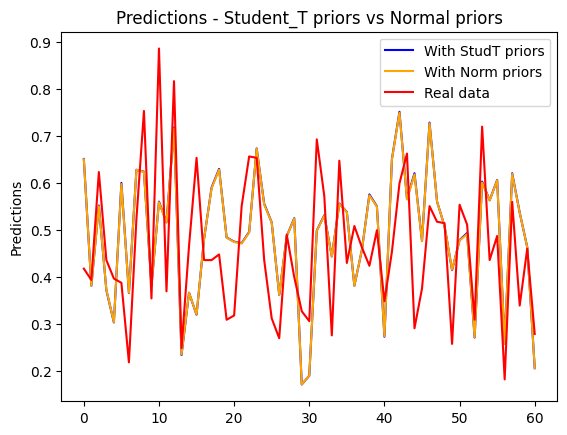

In [ ]:
x_axis = np.arange(len(y_test))

plt.plot(x_axis, y_val_predictions_t, color='blue', label='With StudT priors')
plt.plot(x_axis, y_val_predictions, color='orange', label='With Norm priors')
plt.plot(x_axis, y_test, color='red', label='Real data')
plt.ylabel('Predictions')
plt.title('Predictions - Student_T priors vs Normal priors')
plt.legend()
plt.show()

# **3 - Ridge Regression, inclduing frequentis Ridge and Bayesian Ridge**

## Frequentist Ridge

In [ ]:
ridge = Ridge(alpha=0.8)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

mean_absolute_error(y_test, y_pred)

0.11477127414642622

## Bayesian Ridge

In [ ]:
# Create and fit the Bayesian Linear Regression model
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)

# Predict on the test set
y_pred_bayesian_ridge = bayesian_ridge.predict(X_test)

# Evaluate the model
regression_results(y_test, y_pred_bayesian_ridge)

explained_variance:  0.2248
mean_squared_log_error:  0.0083
r2:  0.1899
MAE:  0.1125
MSE:  0.0183
RMSE:  0.1353


# **4 - Regression Tree, including frequentist and Bayesian Tree**

## Bayesian Tree

In [ ]:
!ls

 bayesian_tree		 helper_functions.py  'Outline and ideas.docx'	 Salary_Prediction.ipynb
 bike_sales_data.csv	 LR.ipynb	       project.ipynb		 Untitled.ipynb
 data_cleaned_2021.csv	 onlinefoods.csv       __pycache__


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Bayesian Analysis")
sys.path.append("/content/drive/MyDrive/Bayesian Analysis/bayesian_tree")
sys.path.append("/content/drive/MyDrive/Bayesian Analysis/bayesian_tree/bayesian_decision_tree")

import bayesian_tree
from bayesian_tree import bayesian_decision_tree
from bayesian_tree import examples
from bayesian_decision_tree import classification
from bayesian_decision_tree.regression import PerpendicularRegressionTree

In [ ]:
mu = y_train.mean()
sd_prior = y_train.std() / 10
prior_pseudo_observations = 1
kappa = prior_pseudo_observations
alpha = prior_pseudo_observations / 2
var_prior = sd_prior**2
tau_prior = 1/var_prior
beta = alpha/tau_prior
prior = np.array([mu, kappa, alpha, beta])

In [ ]:
model = PerpendicularRegressionTree(
        partition_prior=0.9,
        prior=prior,
        delta=0)

In [ ]:
model.fit(np.array(X_train), np.array(y_train))
print("-----------------")
print(model)
print("-----------------")
print('Tree depth and number of leaves: {}, {}'.format(model.get_depth(), model.get_n_leaves()))
print('Feature importance:', model.feature_importance())

# compute accuracy
y_pred_train = model.predict(X_train)
y_pred_bayes_tree = model.predict(X_test)
accuracy_train = mean_absolute_error(y_train, y_pred_train)
accuracy_test = mean_absolute_error(y_test, y_pred_bayes_tree)
info_train = 'Train MAE: {:.4f}'.format(accuracy_train)
info_test = 'Test MAE:  {:.4f}'.format(accuracy_test)
print(info_train)
print(info_test)

-----------------
x3=0.6439855573669326
 ├ <0.6439855573669326: y=0.31201736624456305, n=46
 └ ≥0.6439855573669326: x1=0.31751585662580717
    ├ <0.31751585662580717: y=0.4791298498088772, n=92
    └ ≥0.31751585662580717: y=0.6156998259662296, n=102
-----------------
Tree depth and number of leaves: 2, 3
Feature importance: [0.         0.16438532 0.         0.83561468 0.         0.
 0.         0.         0.         0.        ]
Train MAE: 0.1409
Test MAE:  0.1119


This is how the Bayesian Tree looks like:

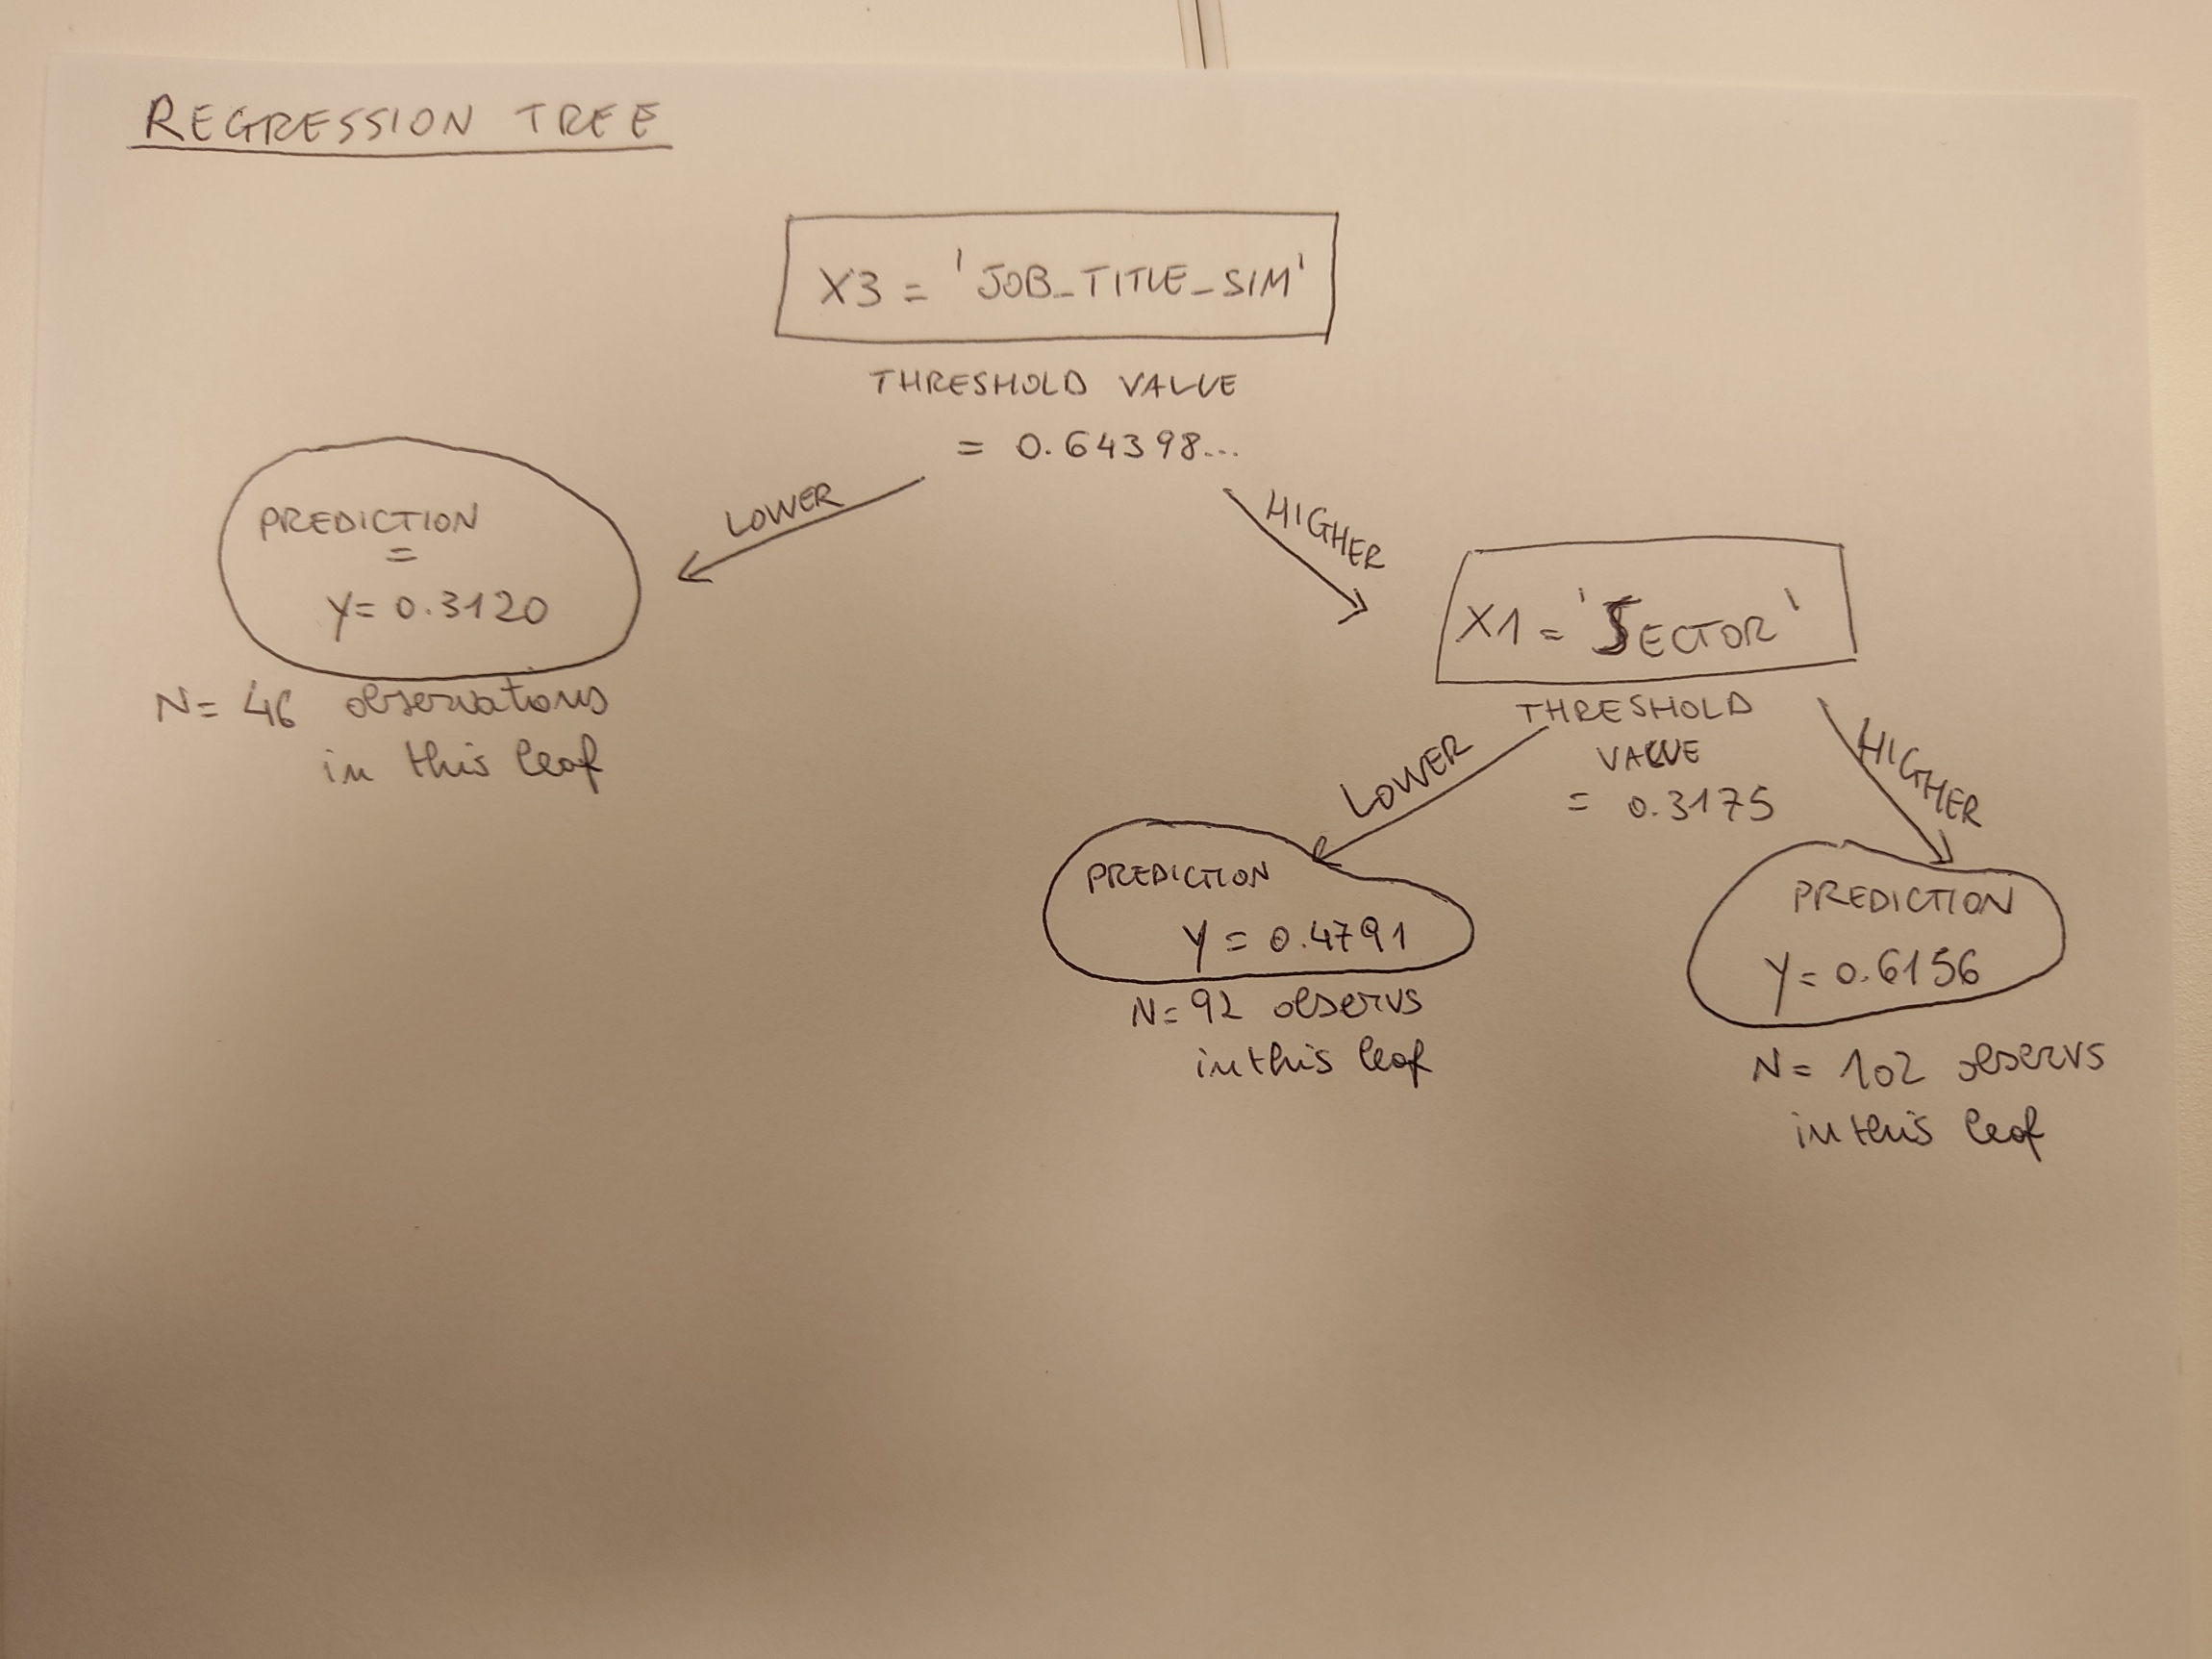

In [ ]:
print(dir(model))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_feature_names', '_check_n_features', '_check_target', '_compute_child1_and_child2_indices', '_compute_log_p_data', '_compute_log_p_data_no_split', '_compute_log_p_data_split', '_compute_posterior', '_compute_posterior_internal', '_compute_posterior_mean', '_create_merged_paths_array', '_ensure_float64', '_ensure_is_fitted', '_erase_split_info', '_erase_split_info_base', '_estimator_type', '_fit', '_get_param_names', '_get_prior', '_get_raw_leaf_data', '_get_raw_leaf_data_internal', '_get_tags', '_more_tags', '_normalize_data_and_feature_names', '_predict', '_p

## Frequentist Bayesian Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
frequentist_tree = DecisionTreeRegressor(random_state=0,
                                         criterion='absolute_error',
                                         max_depth=3,
                                         min_samples_split=4)

In [ ]:
frequentist_tree.fit(X_train, y_train)

y_freq_tree_predictions = frequentist_tree.predict(X_test)

print(f"MAE of the frequentist tree: {mean_absolute_error(y_test, y_freq_tree_predictions)}")

MAE of the frequentist tree: 0.10195136446931802


In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,25))
plot_tree(frequentist_tree)
plt.show()

# **5 - Overall Comparison**

In [ ]:
results_df = pd.DataFrame(
    {'Frequentist LinReg' : mean_absolute_error(y_test, y_val_predictions_nlr),
     'Bayesian LinReg - Normal': mean_absolute_error(y_test, y_val_predictions),
     'Bayesian LinReg - StudT': mean_absolute_error(y_test, y_val_predictions_t),
     'Frequentist Ridge': mean_absolute_error(y_test, y_pred_ridge),
     'Bayesian Ridge': mean_absolute_error(y_test, y_pred_bayesian_ridge),
     'Bayesian Tree': mean_absolute_error(y_test, y_pred_bayes_tree),
     'Frequentist Tree': mean_absolute_error(y_test, y_freq_tree_predictions)}, index=['MAE']
).T

results_df.index.name = 'Models'

results_df['Model_Type'] = ['Bayesian' if 'Bayesian' in index else 'Frequentist' for index in results_df.index]

results_df

,MAE,Model_Type
Models,,
Frequentist LinReg,0.115983,Frequentist
Bayesian LinReg - Normal,0.115929,Bayesian
Bayesian LinReg - StudT,0.116107,Bayesian
Frequentist Ridge,0.114771,Frequentist
Bayesian Ridge,0.112472,Bayesian
Bayesian Tree,0.111877,Bayesian
Frequentist Tree,0.101951,Frequentist


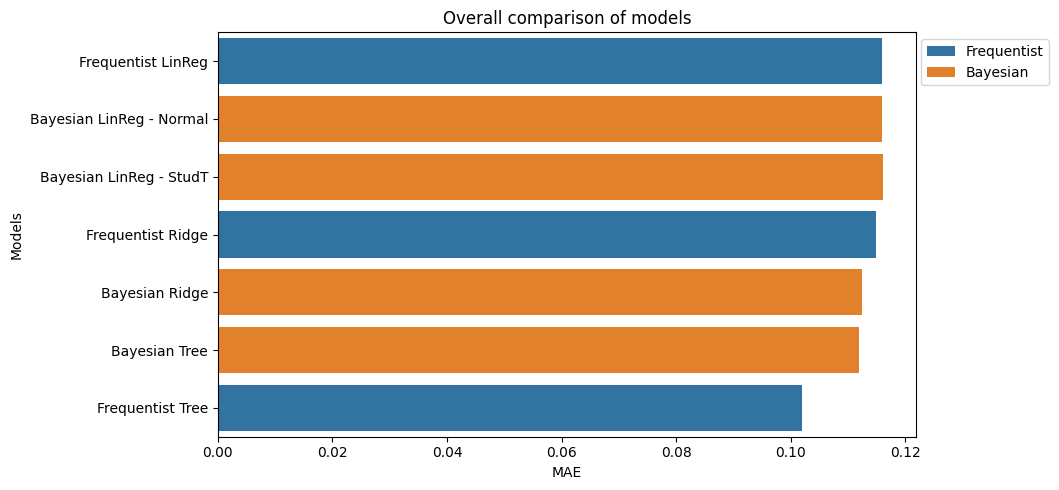

In [ ]:
plt.figure(figsize=(11,5))
sns.barplot(data=results_df, x='MAE', y=results_df.index,
            orient='h', hue='Model_Type')
plt.title('Overall comparison of models')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

# **6 - Feature Importance on Bayesian Lin Reg**

## Simple bar plot

Recall that we already have the coefficients of this model stored in `coefficients_dict`.

In [ ]:
mapping_names = {
    'intercept': 'intercept',
    'beta[0]': 'Type of ownership',
    'beta[1]': 'Sector',
    'beta[2]': 'Revenue',
    'beta[3]': 'job_title_sim',
    'beta[4]': 'Programming',
    'beta[5]': 'Queries',
    'beta[6]': 'Machine Learning',
    'beta[7]': 'Dashboards',
    'beta[8]': 'Cloud',
    'beta[9]': 'Apache'
}

mapped_coefficients_dict = {mapping_names[key]: value for key, value in coefficients_dict.items()}
mapped_coefficients_dict

{'intercept': 0.205,
 'Type of ownership': 0.054,
 'Sector': 0.192,
 'Revenue': 0.023,
 'job_title_sim': 0.212,
 'Programming': 0.068,
 'Queries': 0.063,
 'Machine Learning': 0.057,
 'Dashboards': -0.091,
 'Cloud': 0.037,
 'Apache': 0.024}

In [ ]:
sorted_coefficients = sorted(mapped_coefficients_dict.items(), key=lambda coef_value: np.abs(coef_value[1]), reverse=True)
sorted_coefficients

[('job_title_sim', 0.212),
 ('intercept', 0.205),
 ('Sector', 0.192),
 ('Dashboards', -0.091),
 ('Programming', 0.068),
 ('Queries', 0.063),
 ('Machine Learning', 0.057),
 ('Type of ownership', 0.054),
 ('Cloud', 0.037),
 ('Apache', 0.024),
 ('Revenue', 0.023)]

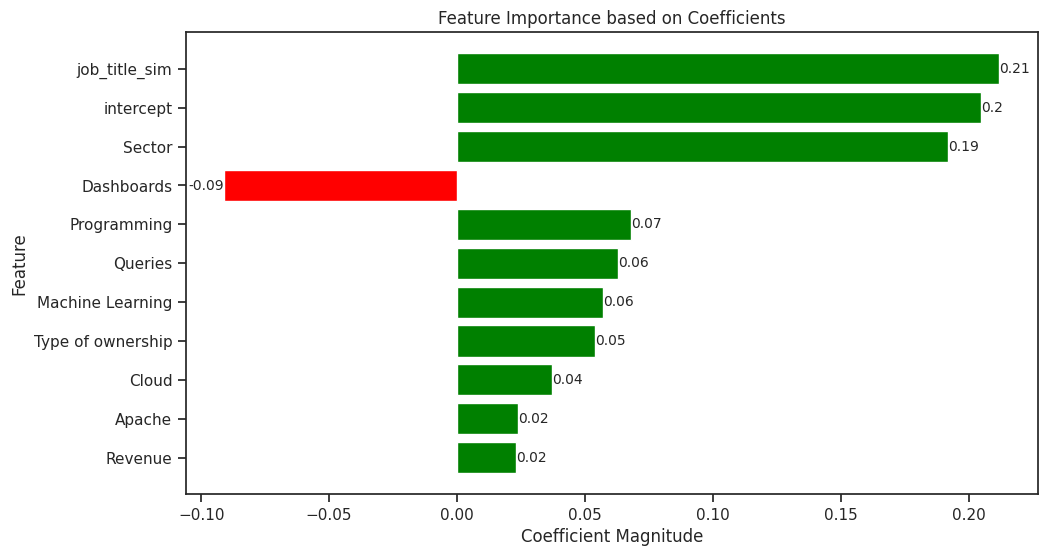

In [ ]:
# Extract feature names and corresponding coefficients
feature_names = [item[0] for item in sorted_coefficients]
coefficients = [item[1] for item in sorted_coefficients]

sns.set(style="ticks")

plt.figure(figsize=(11, 6))

# custom colors for the bars
for feature, coef in zip(feature_names, coefficients):
    color = 'red' if coef < 0 else 'green'
    plt.barh(feature, coef, color=color, align='center')

plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance based on Coefficients')
plt.gca().invert_yaxis()

# add annotations
for feature, coef in zip(feature_names, coefficients):
  if coef>0:
    plt.text(coef, feature, round(coef, 2), va='center', ha='left', fontsize=10)
  else:
    plt.text(coef, feature, round(coef, 2), va='center', ha='right', fontsize=10)

plt.show()


## SHAP values - using Bayesian Ridge because Bayesian LR creates problems

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.explainers.Linear(bayesian_ridge, data)
shap_values = explainer(X_train)

Interpretation of this plot: for the individual having the 21st index in the `X_train`, `having job_title_sim=0` decreased **significantily** his/her salary. I am not sure whether the amount (-0.15) can be interpreted as 15.000$, 15% or what else...

It is important to highlight that this is only a plot for **one single observation** and that the derived conclusions may be different for another individual.

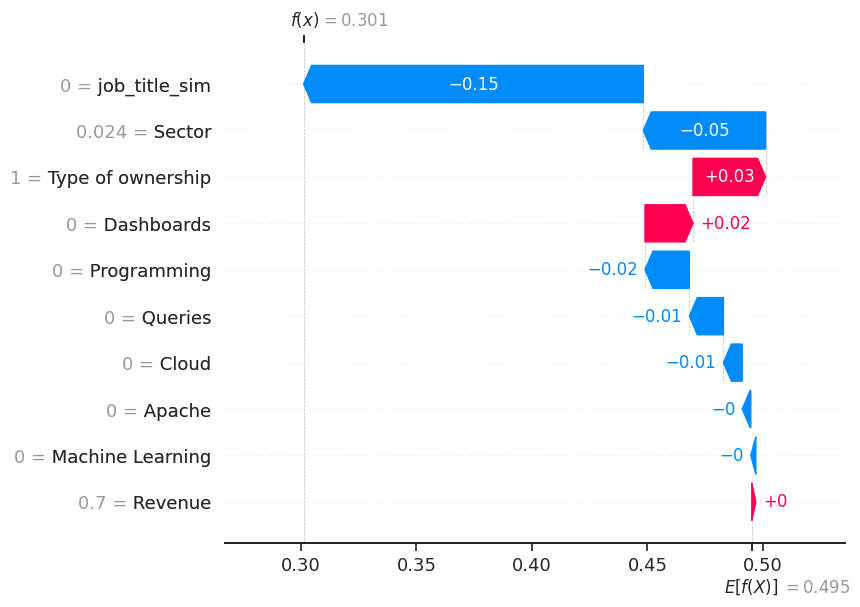

In [ ]:
plt.figure(figsize=(10,8))
shap.plots.waterfall(shap_values[20], max_display=14)

For example, the individual having index 10 in the X_train, has benefitted from the impact of job_title_sim, as its value here is =1.

What also matters is that, for each individual, the predicted value for Salary (SCALED!!!) is 0.495. Starting from this average value, the variables can push the estimate higher or lower, depending on the values they take!

In [ ]:
plt.figure(figsize=(10,8))
shap.plots.waterfall(shap_values[10], max_display=14)

TypeError: waterfall() got an unexpected keyword argument 'plot_size'

<Figure size 1000x800 with 0 Axes>

Let's see which are the SHAP values for the individual earning the highest salary.

In [ ]:
train.loc[train['Avg Salary(K)']==1]

,Type of ownership,Sector,Revenue,job_title_sim,Avg Salary(K),Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
203,0.199679,0.434893,0.2,0.795797,1.0,0.5,0.5,0.5,0.0,0.0,0.333333


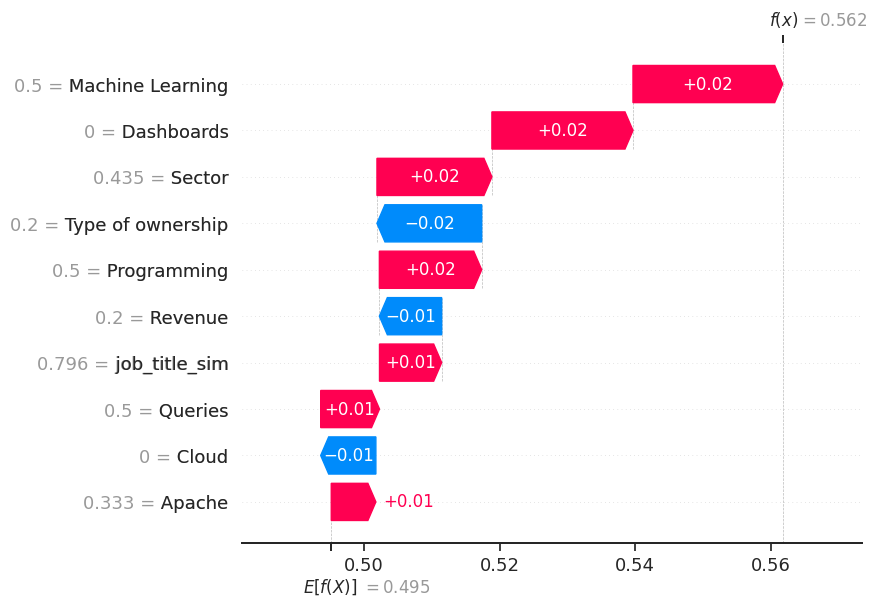

In [ ]:
shap.plots.waterfall(shap_values[203], max_display=14)

Overall picture of the variables.
[Source](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html)

In [ ]:
import warnings

# Suppress specific UserWarnings from SHAP violin plot
warnings.filterwarnings("ignore", message="not enough data in bin", category=UserWarning)

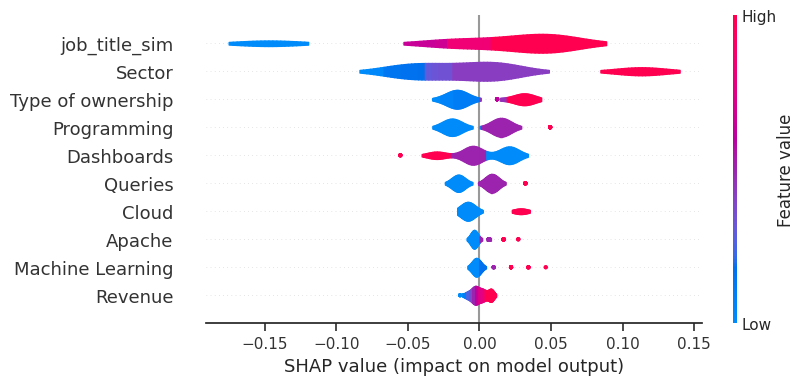

In [ ]:
shap.plots.violin(shap_values, plot_size=0.25)

In [1]:
shap.plots.violin(shap_values, plot_type='layered_violin')

NameError: name 'shap' is not defined

## ELI5

Source:
- https://medium.com/@salonipriyani/explaining-ml-with-eli5-a-guide-for-numerical-computer-vision-and-natural-language-data-e29f18615311#:~:text=ELI5%20can%20be%20used%20to%20explain%20models%20such%20as%20linear,feature%20in%20the%20prediction%20process,
- https://eli5.readthedocs.io/en/latest/autodocs/lime.html?highlight=show_weights#eli5.lime.lime.TextExplainer.show_weights

In [ ]:
!pip install eli5
import eli5

In [ ]:
eli5.show_weights(bayesian_lr_model)

# Potential future developments:
- Do the SHAP analysis based on the real values, i.e. the un-scaled values to preserve interpretability,
- Out-of-sample predictions,
- One more prior distribution in the Linear Model,
- Tuning the Bayesian Linear Model: no idea what to tune though